In [1]:
import numpy as np
import cv2
import os
import re
from PIL import Image
from io import BytesIO
import matplotlib
import matplotlib.pyplot as plt

In [2]:

def aHash(img):
    # 均值哈希算法
    # 缩放为8*8
    img = cv2.resize(img, (8, 8))
    # 转换为灰度图
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # s为像素和初值为0，hash_str为hash值初值为''
    s = 0
    hash_str = ''
    # 遍历累加求像素和
    for i in range(8):
        for j in range(8):
            s = s+gray[i, j]
    # 求平均灰度
    avg = s/64
    # 灰度大于平均值为1相反为0生成图片的hash值
    for i in range(8):
        for j in range(8):
            if gray[i, j] > avg:
                hash_str = hash_str+'1'
            else:
                hash_str = hash_str+'0'
    return hash_str
 

def dHash(img):
    # 差值哈希算法
    # 缩放8*8
    img = cv2.resize(img, (9, 8))
    # 转换灰度图
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hash_str = ''
    # 每行前一个像素大于后一个像素为1，相反为0，生成哈希
    for i in range(8):
        for j in range(8):
            if gray[i, j] > gray[i, j+1]:
                hash_str = hash_str+'1'
            else:
                hash_str = hash_str+'0'
    return hash_str
 

def pHash(img):
    # 感知哈希算法
    # 缩放32*32
    img = cv2.resize(img, (32, 32))   # , interpolation=cv2.INTER_CUBIC
 
    # 转换为灰度图
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 将灰度图转为浮点型，再进行dct变换
    dct = cv2.dct(np.float32(gray))
    # opencv实现的掩码操作
    dct_roi = dct[0:8, 0:8]
 
    hash = []
    avreage = np.mean(dct_roi)
    for i in range(dct_roi.shape[0]):
        for j in range(dct_roi.shape[1]):
            if dct_roi[i, j] > avreage:
                hash.append(1)
            else:
                hash.append(0)
    return hash
 
def calculate(image1, image2):
    # 灰度直方图算法
    # 计算单通道的直方图的相似值
    hist1 = cv2.calcHist([image1], [0], None, [256], [0.0, 255.0])
    hist2 = cv2.calcHist([image2], [0], None, [256], [0.0, 255.0])
    # 计算直方图的重合度
    degree = 0
    for i in range(len(hist1)):
        if hist1[i] != hist2[i]:
            degree = degree + \
                (1 - abs(hist1[i] - hist2[i]) / max(hist1[i], hist2[i]))
        else:
            degree = degree + 1
    degree = degree / len(hist1)
    return degree
  
def classify_hist_with_split(image1, image2, size=(256, 256)):
    # RGB每个通道的直方图相似度
    # 将图像resize后，分离为RGB三个通道，再计算每个通道的相似值
    image1 = cv2.resize(image1, size)
    image2 = cv2.resize(image2, size)
    sub_image1 = cv2.split(image1)
    sub_image2 = cv2.split(image2)
    sub_data = 0
    for im1, im2 in zip(sub_image1, sub_image2):
        sub_data += calculate(im1, im2)
    sub_data = sub_data / 3
    return sub_data
 

def cmpHash(hash1, hash2):
    # Hash值对比
    # 算法中1和0顺序组合起来的即是图片的指纹hash。顺序不固定，但是比较的时候必须是相同的顺序。
    # 对比两幅图的指纹，计算汉明距离，即两个64位的hash值有多少是不一样的，不同的位数越小，图片越相似
    # 汉明距离：一组二进制数据变成另一组数据所需要的步骤，可以衡量两图的差异，汉明距离越小，则相似度越高。汉明距离为0，即两张图片完全一样
    n = 0
    # hash长度不同则返回-1代表传参出错
    if len(hash1) != len(hash2):
        return -1
    # 遍历判断
    for i in range(len(hash1)):
        # 不相等则n计数+1，n最终为相似度
        if hash1[i] != hash2[i]:
            n = n + 1
    return n
 
def runAllImageSimilaryFun(para1, para2):
    # 均值、差值、感知哈希算法三种算法值越小，则越相似,相同图片值为0
    # 三直方图算法和单通道的直方图 0-1之间，值越大，越相似。 相同图片为1
 
    # t1,t2   14;19;10;  0.70;0.75
    # t1,t3   39 33 18   0.58 0.49
    # s1,s2  7 23 11     0.83 0.86  挺相似的图片
    # c1,c2  11 29 17    0.30 0.31
 

    # 通过imread方法直接读取物理路径
    img1 = cv2.imread(para1)
    img2 = cv2.imread(para2)
 
    hash1 = aHash(img1)
    hash2 = aHash(img2)
    n1 = cmpHash(hash1, hash2)
    print('均值哈希算法相似度aHash：', n1)
 
    hash1 = dHash(img1)
    hash2 = dHash(img2)
    n2 = cmpHash(hash1, hash2)
    print('差值哈希算法相似度dHash：', n2)
 
    hash1 = pHash(img1)
    hash2 = pHash(img2)
    n3 = cmpHash(hash1, hash2)
    print('感知哈希算法相似度pHash：', n3)
 
    n4 = classify_hist_with_split(img1, img2)
    print('三直方图算法相似度：', n4)
 
    n5 = calculate(img1, img2)
    print("单通道的直方图", n5)
    print("%d %d %d %.2f %.2f " % (n1, n2, n3, round(n4[0], 2), n5[0]))
    print("%.2f %.2f %.2f %.2f %.2f " % (1-float(n1/64), 1 -
                                         float(n2/64), 1-float(n3/64), round(n4[0], 2), n5[0]))
 

In [3]:
def read_pic_img(pic_path):
    regex = re.compile(r'[\u4e00-\u9fa5]')
    result = regex.search(pic_path)
    if result is None:
        img = cv2.imread(pic_path)
    else:
        img = cv2.imdecode(np.fromfile(pic_path, dtype=np.uint8), -1)
    return img

In [7]:
new_src_imgs = {}

In [8]:
def compare_pictures(abs_src, src, abs_dest, dest):
    src_pictures = os.listdir(abs_src)
    abs_src_pictures = [os.path.join(abs_src, src_pic) for src_pic in src_pictures]
    dest_pictures = os.listdir(abs_dest)
    abs_dest_pictures = [os.path.join(abs_dest, dest_pic) for dest_pic in dest_pictures]
    regex = re.compile(r'[\u4e00-\u9fa5]')

    for i in range(0, len(src_pictures)):
        src_pic = src_pictures[i]
        if new_src_imgs.get(src) is None:
            src_img = read_pic_img(abs_src_pictures[i])
            new_src_imgs[src] = {}
            new_src_imgs[src][src_pic] = src_img
        else:
            if new_src_imgs[src].get(src_pic) is None:
                src_img = read_pic_img(abs_src_pictures[i])
                new_src_imgs[src][src_pic] = src_img
            else:
                src_img = new_src_imgs[src][src_pic]

        for j in range(0, len(dest_pictures)):
            dest_pic = dest_pictures[j]
            dest_img = read_pic_img(abs_dest_pictures[j])
            n1 = cmpHash(aHash(src_img), aHash(dest_img))
            n2 = classify_hist_with_split(src_img, dest_img)
            if n1 < 5 or n2[0] > 0.8:
                print("相同图片为{0} : {1}".format(src_pic, dest_pic))
                plt.subplot(121)
                plt.imshow(Image.open(abs_src_pictures[i]))
                plt.subplot(122)
                plt.imshow(Image.open(abs_dest_pictures[j]))
                plt.show()
                print("相同文件夹为{0} : {1} ".format(abs_src, abs_dest))
                return True
    return False

In [9]:
def is_same_new_pictures(new_dir, pic_dir):
    rel_new_dir = os.path.basename(new_dir)
    pictures = os.listdir(pic_dir)
    abs_pictures = [os.path.join(pic_dir, picture) for picture in pictures]
      
    print("原始文件夹：", new_dir)
    for i in range(0, len(pictures)):
        print("比较文件夹：", pictures[i])
        if compare_pictures(new_dir, rel_new_dir, abs_pictures[i], pictures[i]):
            break
               

原始文件夹： C:\Users\shenshen\Desktop\test\请自备纸巾！女神周妍希倾情奉献,全裸泡泡浴画面太香艳
比较文件夹： [MICAT瑞丝馆] Vol.041 女神@土肥圆矮挫穷服装主题写真
比较文件夹： [MiStar魅妍社] Vol.167 女神@土肥圆矮挫穷沙巴旅拍写真
相同图片为28b01.jpg : 10.jpg


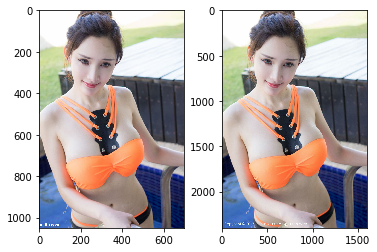

相同文件夹为C:\Users\shenshen\Desktop\test\请自备纸巾！女神周妍希倾情奉献,全裸泡泡浴画面太香艳 : D:\tool\CAJ\丝足\土肥圆周妍希\[MiStar魅妍社] Vol.167 女神@土肥圆矮挫穷沙巴旅拍写真 


In [10]:
is_same_new_pictures(r'C:\Users\shenshen\Desktop\test\请自备纸巾！女神周妍希倾情奉献,全裸泡泡浴画面太香艳', r'D:\tool\CAJ\丝足\土肥圆周妍希')

In [ ]:
is_same_new_pictures(r'C:\Users\shenshen\Desktop\test\似露非露,撩人心菲 性感女神周妍希巴厘岛销魂SPA水中缠绵', r'D:\tool\CAJ\丝足\土肥圆周妍希')

In [ ]:
is_same_new_pictures(r'C:\Users\shenshen\Desktop\test\无圣光宅福利 性感美女周妍希再爆大尺度情趣私照', r'D:\tool\CAJ\丝足\土肥圆周妍希')

In [ ]:
is_same_new_pictures(r'C:\Users\shenshen\Desktop\test\性感乳神周妍希火辣身材撩人欲火', r'D:\tool\CAJ\丝足\土肥圆周妍希')

In [ ]:
is_same_new_pictures(r'C:\Users\shenshen\Desktop\test\性感尤物周妍希OL制服美腿诱惑，黑丝秘书装撩翻总裁', r'D:\tool\CAJ\丝足\土肥圆周妍希')

In [ ]:
is_same_new_pictures(r'C:\Users\shenshen\Desktop\test\秀人网 爆乳嫩模奶瓶土肥圆矮挫丑黑穷蕾丝情趣装大尺度写真 第1651期', r'D:\tool\CAJ\丝足\土肥圆周妍希')

In [ ]:
is_same_new_pictures(r'C:\Users\shenshen\Desktop\test\浴衣美人周妍希爆乳美腿真性感 纵情自摸表情销魂', r'D:\tool\CAJ\丝足\土肥圆周妍希')